In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
import torch.utils.data as data
from torchvision import datasets, models, transforms
import time
import json
import copy
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
data_dir = 'D:/Z-kobehsegu/Datasets/animal_png'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [3]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

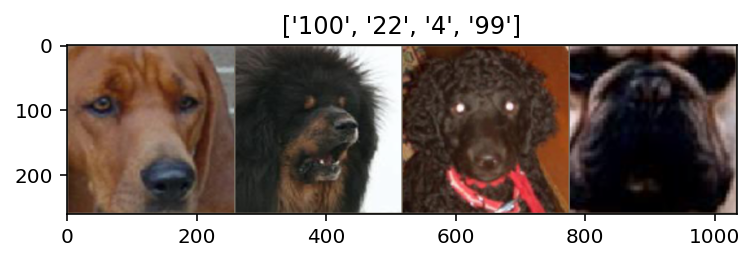

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
model_ft = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 149)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [8]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                # print(labels)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                print(best_acc)
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./animal_point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft,num_epochs=200)

Epoch 0/199
----------
train Loss: 1.1999 Acc: 0.0174
tensor(0.0174, device='cuda:0')

Epoch 1/199
----------
train Loss: 1.1360 Acc: 0.0313
tensor(0.0313, device='cuda:0')

Epoch 2/199
----------
train Loss: 1.1012 Acc: 0.0439
tensor(0.0439, device='cuda:0')

Epoch 3/199
----------
train Loss: 1.0751 Acc: 0.0529
tensor(0.0529, device='cuda:0')

Epoch 4/199
----------
train Loss: 1.0538 Acc: 0.0567
tensor(0.0567, device='cuda:0')

Epoch 5/199
----------
train Loss: 1.0368 Acc: 0.0663
tensor(0.0663, device='cuda:0')

Epoch 6/199
----------
train Loss: 1.0213 Acc: 0.0741
tensor(0.0741, device='cuda:0')

Epoch 7/199
----------
train Loss: 1.0113 Acc: 0.0775
tensor(0.0775, device='cuda:0')

Epoch 8/199
----------
train Loss: 0.9964 Acc: 0.0895
tensor(0.0895, device='cuda:0')

Epoch 9/199
----------
train Loss: 0.9832 Acc: 0.0959
tensor(0.0959, device='cuda:0')

Epoch 10/199
----------
train Loss: 0.9735 Acc: 0.1076
tensor(0.1076, device='cuda:0')

Epoch 11/199
----------
train Loss: 0.9607

train Loss: 0.0218 Acc: 0.9868

Epoch 98/199
----------
train Loss: 0.0202 Acc: 0.9892
tensor(0.9892, device='cuda:0')

Epoch 99/199
----------
train Loss: 0.0197 Acc: 0.9892

Epoch 100/199
----------
train Loss: 0.0194 Acc: 0.9892
tensor(0.9892, device='cuda:0')

Epoch 101/199
----------
train Loss: 0.0187 Acc: 0.9890

Epoch 102/199
----------
train Loss: 0.0183 Acc: 0.9903
tensor(0.9903, device='cuda:0')

Epoch 103/199
----------
train Loss: 0.0183 Acc: 0.9885

Epoch 104/199
----------
train Loss: 0.0171 Acc: 0.9900

Epoch 105/199
----------
train Loss: 0.0184 Acc: 0.9892

Epoch 106/199
----------
train Loss: 0.0165 Acc: 0.9913
tensor(0.9913, device='cuda:0')

Epoch 107/199
----------
train Loss: 0.0155 Acc: 0.9913

Epoch 108/199
----------
train Loss: 0.0167 Acc: 0.9903

Epoch 109/199
----------
train Loss: 0.0143 Acc: 0.9921
tensor(0.9921, device='cuda:0')

Epoch 110/199
----------
train Loss: 0.0149 Acc: 0.9913

Epoch 111/199
----------
train Loss: 0.0144 Acc: 0.9924
tensor(0.9924

In [11]:
model_ft_2 = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft_2.fc.in_features
model_ft_2.fc = nn.Linear(num_ftrs, 149)
checkpoint = torch.load('D:/Z-kobehsegu/Jupyter/animal_point_resnet_best.pth')
model_ft_2.load_state_dict(checkpoint['model'])
#state_dict = checkpoint['state_dist']
optimizer_ft.load_state_dict(checkpoint['optim'])
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_2 = model_ft_2.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft_2.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_2 = model_ft_2.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft_2.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [29]:
data_dir = 'D:/Z-kobehsegu/Datasets/animal_png/test_original'
train_dir = data_dir + '/train'
var_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [30]:
def train_model(model, criterion, optimizer, num_epochs=30):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
               # print(labels)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./animal_test_point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [31]:
model_ft_2 = train_model(model_ft_2, criterion, optimizer_ft,num_epochs=30)

Epoch 0/29
----------
train Loss: 0.0038 Acc: 0.9978
valid Loss: 1.1831 Acc: 0.2019

Epoch 1/29
----------
train Loss: 0.0018 Acc: 0.9978
valid Loss: 1.2153 Acc: 0.1914

Epoch 2/29
----------
train Loss: 0.0014 Acc: 1.0000
valid Loss: 1.2190 Acc: 0.2010

Epoch 3/29
----------
train Loss: 0.0021 Acc: 1.0000
valid Loss: 1.2065 Acc: 0.1943

Epoch 4/29
----------
train Loss: 0.0013 Acc: 1.0000
valid Loss: 1.2024 Acc: 0.2029

Epoch 5/29
----------
train Loss: 0.0020 Acc: 0.9989
valid Loss: 1.1817 Acc: 0.2019

Epoch 6/29
----------
train Loss: 0.0015 Acc: 1.0000
valid Loss: 1.2409 Acc: 0.2105

Epoch 7/29
----------
train Loss: 0.0023 Acc: 0.9967
valid Loss: 1.2068 Acc: 0.1867

Epoch 8/29
----------
train Loss: 0.0033 Acc: 0.9967
valid Loss: 1.1899 Acc: 0.2038

Epoch 9/29
----------
train Loss: 0.0024 Acc: 0.9989
valid Loss: 1.2010 Acc: 0.2124

Epoch 10/29
----------
train Loss: 0.0024 Acc: 0.9978
valid Loss: 1.2129 Acc: 0.2000

Epoch 11/29
----------
train Loss: 0.0023 Acc: 0.9989
valid Loss

In [32]:
def calc_accuracy(model, datas):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for data in dataloaders[datas]:
                # get the inputs
        inputs, labels = data
        print(labels)
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        running_corrects += torch.sum(predicted == labels)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))
    '''# check the 
    if idx == 0:
        print(predicted) #the predicted class
        print(torch.exp(_)) # the predicted probability
    equals = predicted == labels.data
    if idx == 0:
        print(equals)
    print(equals.float().mean())'''
calc_accuracy(model_ft_2, 'test')

tensor([20,  3, 15, 18])
tensor([20,  3, 15,  0], device='cuda:0')
tensor([ 8,  8, 29, 25])
tensor([ 8, 25, 16, 25], device='cuda:0')
tensor([23,  7,  6, 24])
tensor([ 0, 26,  8, 10], device='cuda:0')
tensor([27, 23, 12, 19])
tensor([27, 25,  9, 28], device='cuda:0')
tensor([27, 12,  9,  1])
tensor([26, 22,  9, 23], device='cuda:0')
tensor([11,  7, 10,  0])
tensor([ 5, 21, 10,  9], device='cuda:0')
tensor([16, 14, 19, 24])
tensor([16, 20, 16, 27], device='cuda:0')
tensor([21, 21, 28,  4])
tensor([ 2, 16, 28, 21], device='cuda:0')
tensor([ 4,  8,  5, 29])
tensor([ 4, 11, 17, 22], device='cuda:0')
tensor([15, 20,  3, 17])
tensor([11, 20, 29, 17], device='cuda:0')
tensor([ 3,  6, 21,  2])
tensor([ 3, 61,  0,  2], device='cuda:0')
tensor([11, 28, 27,  0])
tensor([17,  1,  2,  0], device='cuda:0')
tensor([29,  4,  6, 21])
tensor([29,  3, 26,  4], device='cuda:0')
tensor([11,  4, 15, 26])
tensor([17, 21, 11, 15], device='cuda:0')
tensor([ 4, 18, 18,  6])
tensor([12, 18, 16,  3], device='cuda

tensor([ 8, 12,  5,  7])
tensor([ 8, 12,  4, 19], device='cuda:0')
tensor([25,  7,  5, 25])
tensor([17,  6,  5, 25], device='cuda:0')
tensor([24,  6,  7, 19])
tensor([28, 20, 24, 18], device='cuda:0')
tensor([16, 15,  5, 23])
tensor([ 5, 15, 17, 12], device='cuda:0')
tensor([ 9, 14,  6, 14])
tensor([11, 24, 11,  6], device='cuda:0')
tensor([18, 21,  4,  3])
tensor([ 22,  11,   0, 103], device='cuda:0')
tensor([ 3, 10, 15,  6])
tensor([ 3, 27,  9,  9], device='cuda:0')
tensor([17, 16,  9,  0])
tensor([ 5, 16, 26, 21], device='cuda:0')
tensor([16, 12, 25, 18])
tensor([16,  3, 17,  9], device='cuda:0')
tensor([ 9, 23, 20,  3])
tensor([ 9, 18, 22,  6], device='cuda:0')
tensor([26, 16, 20, 24])
tensor([26, 16, 20, 19], device='cuda:0')
tensor([22, 13, 26, 19])
tensor([14,  9, 13, 16], device='cuda:0')
tensor([28,  4,  1,  6])
tensor([28, 23, 16, 23], device='cuda:0')
tensor([12, 13, 22,  7])
tensor([  1,  13,  27, 108], device='cuda:0')
tensor([26,  2, 26,  8])
tensor([21, 26, 18,  3], devi

In [34]:
data_dir = 'D:/Z-kobehsegu/Datasets/animal_png/test_loFGAN'
train_dir = data_dir + '/train'
var_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [35]:
model_ft_3 = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft_3.fc.in_features
model_ft_3.fc = nn.Linear(num_ftrs, 149)
checkpoint = torch.load('D:/Z-kobehsegu/Jupyter/animal_point_resnet_best.pth')
model_ft_3.load_state_dict(checkpoint['model'])
#state_dict = checkpoint['state_dist']
optimizer_ft.load_state_dict(checkpoint['optim'])
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_3 = model_ft_3.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function

optimizer_ft = optim.SGD(model_ft_3.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [36]:
def train_model(model, criterion, optimizer, num_epochs=30):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                # print(labels)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./LofGAN_Augment_Animal_test_point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [37]:
model_ft_3 = train_model(model_ft_3, criterion, optimizer_ft,num_epochs=30)

Epoch 0/29
----------
train Loss: 0.9348 Acc: 0.2587
valid Loss: 0.8344 Acc: 0.2162

Epoch 1/29
----------
train Loss: 0.3577 Acc: 0.6246
valid Loss: 0.8096 Acc: 0.2743

Epoch 2/29
----------
train Loss: 0.2016 Acc: 0.7896
valid Loss: 0.8793 Acc: 0.2733

Epoch 3/29
----------
train Loss: 0.1093 Acc: 0.8833
valid Loss: 0.8981 Acc: 0.2724

Epoch 4/29
----------
train Loss: 0.0740 Acc: 0.9258
valid Loss: 0.9213 Acc: 0.2867

Epoch 5/29
----------
train Loss: 0.0551 Acc: 0.9488
valid Loss: 0.9481 Acc: 0.3019

Epoch 6/29
----------
train Loss: 0.0384 Acc: 0.9629
valid Loss: 0.9858 Acc: 0.2714

Epoch 7/29
----------
train Loss: 0.0346 Acc: 0.9704
valid Loss: 0.9664 Acc: 0.2886

Epoch 8/29
----------
train Loss: 0.0297 Acc: 0.9754
valid Loss: 1.0035 Acc: 0.2943

Epoch 9/29
----------
train Loss: 0.0250 Acc: 0.9792
valid Loss: 1.0052 Acc: 0.2924

Epoch 10/29
----------
train Loss: 0.0232 Acc: 0.9796
valid Loss: 0.9844 Acc: 0.2952

Epoch 11/29
----------
train Loss: 0.0166 Acc: 0.9888
valid Loss

In [38]:
def calc_accuracy(model, datas):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for data in dataloaders[datas]:
                # get the inputs
        inputs, labels = data
        print(labels)
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        running_corrects += torch.sum(predicted == labels)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))
    '''# check the 
    if idx == 0:
        print(predicted) #the predicted class
        print(torch.exp(_)) # the predicted probability
    equals = predicted == labels.data
    if idx == 0:
        print(equals)
    print(equals.float().mean())'''
calc_accuracy(model_ft_3, 'test')

tensor([28, 25,  6, 19])
tensor([27, 25, 15, 19], device='cuda:0')
tensor([ 4, 14, 11,  7])
tensor([ 4, 14, 21,  6], device='cuda:0')
tensor([ 8, 16, 24, 17])
tensor([27,  3, 13,  5], device='cuda:0')
tensor([ 3, 19, 23, 15])
tensor([ 3, 19,  3,  9], device='cuda:0')
tensor([23,  7, 27, 23])
tensor([ 7,  7, 28,  1], device='cuda:0')
tensor([16,  2,  1, 15])
tensor([ 3, 26,  1, 21], device='cuda:0')
tensor([11, 24,  3,  6])
tensor([ 1, 24,  3, 28], device='cuda:0')
tensor([15, 21, 22, 26])
tensor([29, 21, 22, 26], device='cuda:0')
tensor([ 8, 25, 19, 19])
tensor([ 3, 25,  6, 19], device='cuda:0')
tensor([24,  0, 27, 11])
tensor([19, 11,  2,  1], device='cuda:0')
tensor([27,  4, 18, 24])
tensor([ 2, 23, 21, 16], device='cuda:0')
tensor([27,  1, 17, 26])
tensor([13,  1, 19, 26], device='cuda:0')
tensor([ 4,  9, 28, 15])
tensor([21,  9, 28, 19], device='cuda:0')
tensor([ 9, 28, 26, 13])
tensor([ 9,  1, 24, 25], device='cuda:0')
tensor([25, 29, 26,  5])
tensor([18, 28, 24, 12], device='cuda

tensor([ 2,  1, 10, 22])
tensor([10, 35, 10,  0], device='cuda:0')
tensor([17,  6, 15, 18])
tensor([17, 14,  9,  6], device='cuda:0')
tensor([18,  4,  3,  8])
tensor([29,  0, 10,  4], device='cuda:0')
tensor([26,  9, 16, 25])
tensor([ 3, 11, 24, 22], device='cuda:0')
tensor([15,  7, 29, 24])
tensor([14, 17, 18, 24], device='cuda:0')
tensor([25,  1, 18,  2])
tensor([25,  1,  7,  2], device='cuda:0')
tensor([23, 26,  2, 27])
tensor([12, 17, 26,  2], device='cuda:0')
tensor([ 2, 10,  8,  7])
tensor([ 9, 26, 25,  2], device='cuda:0')
tensor([14, 10,  3, 14])
tensor([20, 10,  3, 10], device='cuda:0')
tensor([29,  6,  6,  2])
tensor([15, 14, 21, 27], device='cuda:0')
tensor([23,  0,  9, 10])
tensor([ 6, 21,  9, 74], device='cuda:0')
tensor([ 5, 17, 10,  5])
tensor([ 0, 21, 10,  5], device='cuda:0')
tensor([ 0, 27, 24, 29])
tensor([25, 18,  3, 27], device='cuda:0')
tensor([19, 21,  5,  6])
tensor([19, 20,  5, 15], device='cuda:0')
tensor([14, 14, 26, 28])
tensor([24, 26, 29, 28], device='cuda

In [39]:
data_dir = 'D:/Z-kobehsegu/Datasets/animal_png/test_waveGAN_B'
train_dir = data_dir + '/train'
var_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [40]:
model_ft_4 = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft_4.fc.in_features
model_ft_4.fc = nn.Linear(num_ftrs, 149)
checkpoint = torch.load('D:/Z-kobehsegu/Jupyter/animal_point_resnet_best.pth')
model_ft_4.load_state_dict(checkpoint['model'])
#state_dict = checkpoint['state_dist']
optimizer_ft.load_state_dict(checkpoint['optim'])
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_4 = model_ft_4.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft_4.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [41]:
model_ft_4 = train_model(model_ft_4, criterion, optimizer_ft,num_epochs=30)

Epoch 0/29
----------
train Loss: 0.8178 Acc: 0.3913
valid Loss: 0.7922 Acc: 0.2648

Epoch 1/29
----------
train Loss: 0.2602 Acc: 0.7275
valid Loss: 0.7748 Acc: 0.3048

Epoch 2/29
----------
train Loss: 0.1435 Acc: 0.8567
valid Loss: 0.8561 Acc: 0.3000

Epoch 3/29
----------
train Loss: 0.0764 Acc: 0.9258
valid Loss: 0.8629 Acc: 0.3010

Epoch 4/29
----------
train Loss: 0.0452 Acc: 0.9608
valid Loss: 0.8727 Acc: 0.3305

Epoch 5/29
----------
train Loss: 0.0376 Acc: 0.9633
valid Loss: 0.9235 Acc: 0.3124

Epoch 6/29
----------
train Loss: 0.0287 Acc: 0.9733
valid Loss: 0.9349 Acc: 0.3114

Epoch 7/29
----------
train Loss: 0.0201 Acc: 0.9846
valid Loss: 0.9579 Acc: 0.3095

Epoch 8/29
----------
train Loss: 0.0216 Acc: 0.9796
valid Loss: 0.9464 Acc: 0.3038

Epoch 9/29
----------
train Loss: 0.0162 Acc: 0.9854
valid Loss: 0.9545 Acc: 0.3076

Epoch 10/29
----------
train Loss: 0.0116 Acc: 0.9917
valid Loss: 0.9433 Acc: 0.3048

Epoch 11/29
----------
train Loss: 0.0139 Acc: 0.9892
valid Loss

In [42]:
def calc_accuracy(model, datas):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for data in dataloaders[datas]:
                # get the inputs
        inputs, labels = data
        print(labels)
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        running_corrects += torch.sum(predicted == labels)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))
    '''# check the 
    if idx == 0:
        print(predicted) #the predicted class
        print(torch.exp(_)) # the predicted probability
    equals = predicted == labels.data
    if idx == 0:
        print(equals)
    print(equals.float().mean())'''
calc_accuracy(model_ft_4, 'test')

tensor([11,  8, 10,  6])
tensor([11,  8, 11, 10], device='cuda:0')
tensor([17, 14, 12, 25])
tensor([17, 14, 16, 12], device='cuda:0')
tensor([17, 22, 24, 18])
tensor([22, 10, 16, 18], device='cuda:0')
tensor([ 6,  5,  1, 10])
tensor([ 6,  4, 12, 10], device='cuda:0')
tensor([16, 24, 14, 18])
tensor([16,  9,  7,  4], device='cuda:0')
tensor([11, 23, 18, 21])
tensor([22, 10,  7, 21], device='cuda:0')
tensor([20, 17, 28, 14])
tensor([25,  5, 14, 10], device='cuda:0')
tensor([ 1,  3, 19, 13])
tensor([28,  3, 19,  5], device='cuda:0')
tensor([22, 16, 13, 27])
tensor([11, 16, 24, 10], device='cuda:0')
tensor([ 5, 21, 13, 19])
tensor([ 5, 17, 13, 19], device='cuda:0')
tensor([14,  9,  1, 20])
tensor([27,  6, 12, 14], device='cuda:0')
tensor([15,  8,  7,  0])
tensor([15, 35,  7,  0], device='cuda:0')
tensor([28, 10,  5, 18])
tensor([19, 14, 22, 26], device='cuda:0')
tensor([19,  5, 21,  3])
tensor([19, 17, 16, 14], device='cuda:0')
tensor([27, 21, 20,  6])
tensor([13, 23, 10,  6], device='cuda

tensor([ 2, 24, 26, 10])
tensor([ 2, 19, 26, 10], device='cuda:0')
tensor([13, 24,  3,  2])
tensor([13,  9, 10,  0], device='cuda:0')
tensor([ 0,  5, 25, 16])
tensor([12,  5, 25, 16], device='cuda:0')
tensor([ 6, 27,  6, 29])
tensor([ 6, 27, 14, 26], device='cuda:0')
tensor([23, 18, 15, 16])
tensor([13, 18, 15, 16], device='cuda:0')
tensor([ 8, 21,  8, 22])
tensor([13, 11,  3, 15], device='cuda:0')
tensor([15, 29, 27, 22])
tensor([ 9, 18,  2, 22], device='cuda:0')
tensor([25,  5, 27, 14])
tensor([12,  5, 27, 26], device='cuda:0')
tensor([21,  6, 26, 14])
tensor([22, 10, 26, 10], device='cuda:0')
tensor([21, 19, 21, 20])
tensor([ 4, 29, 21, 14], device='cuda:0')
tensor([14, 11, 15,  1])
tensor([14,  0, 13, 23], device='cuda:0')
tensor([13,  0, 28, 10])
tensor([13,  0, 28, 10], device='cuda:0')
tensor([21, 13, 18,  0])
tensor([21,  9, 12,  5], device='cuda:0')
tensor([14,  9, 19, 27])
tensor([19,  9, 19, 27], device='cuda:0')
tensor([10,  4, 20,  4])
tensor([10,  9,  6, 13], device='cuda

In [43]:
data_dir = 'D:/Z-kobehsegu/Datasets/animal_png/test_waveGAN_M'
train_dir = data_dir + '/train'
var_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [44]:
model_ft_5 = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft_5.fc.in_features
model_ft_5.fc = nn.Linear(num_ftrs, 149)
checkpoint = torch.load('D:/Z-kobehsegu/Jupyter/animal_point_resnet_best.pth')
model_ft_5.load_state_dict(checkpoint['model'])
#state_dict = checkpoint['state_dist']
optimizer_ft.load_state_dict(checkpoint['optim'])
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_5 = model_ft_5.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft_5.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [45]:
def train_model(model, criterion, optimizer, num_epochs=30):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                # print(labels)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./Animal_waveGAN_M_Augment_test_point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [46]:
model_ft_5 = train_model(model_ft_5, criterion, optimizer_ft,num_epochs=30)

Epoch 0/29
----------
train Loss: 0.8876 Acc: 0.2992
valid Loss: 0.8478 Acc: 0.2219

Epoch 1/29
----------
train Loss: 0.3023 Acc: 0.6854
valid Loss: 0.8535 Acc: 0.2533

Epoch 2/29
----------
train Loss: 0.1665 Acc: 0.8238
valid Loss: 0.8941 Acc: 0.2533

Epoch 3/29
----------
train Loss: 0.1050 Acc: 0.8900
valid Loss: 0.9170 Acc: 0.2629

Epoch 4/29
----------
train Loss: 0.0660 Acc: 0.9379
valid Loss: 0.9624 Acc: 0.2657

Epoch 5/29
----------
train Loss: 0.0401 Acc: 0.9617
valid Loss: 0.9929 Acc: 0.2695

Epoch 6/29
----------
train Loss: 0.0333 Acc: 0.9671
valid Loss: 1.0041 Acc: 0.2800

Epoch 7/29
----------
train Loss: 0.0268 Acc: 0.9767
valid Loss: 0.9922 Acc: 0.3000

Epoch 8/29
----------
train Loss: 0.0250 Acc: 0.9763
valid Loss: 1.0792 Acc: 0.2657

Epoch 9/29
----------
train Loss: 0.0206 Acc: 0.9817
valid Loss: 1.0023 Acc: 0.2724

Epoch 10/29
----------
train Loss: 0.0195 Acc: 0.9833
valid Loss: 1.0011 Acc: 0.2810

Epoch 11/29
----------
train Loss: 0.0183 Acc: 0.9854
valid Loss

In [48]:
def calc_accuracy(model, datas):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for data in dataloaders[datas]:
                # get the inputs
        inputs, labels = data
        print(labels)
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        running_corrects += torch.sum(predicted == labels)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))
    '''# check the 
    if idx == 0:
        print(predicted) #the predicted class
        print(torch.exp(_)) # the predicted probability
    equals = predicted == labels.data
    if idx == 0:
        print(equals)
    print(equals.float().mean())'''
calc_accuracy(model_ft_5, 'test')

tensor([23, 15, 22, 20])
tensor([10,  8, 10, 20], device='cuda:0')
tensor([ 1, 17, 29, 19])
tensor([21,  5, 14, 19], device='cuda:0')
tensor([15,  6, 21, 28])
tensor([ 4,  6,  4, 28], device='cuda:0')
tensor([10,  0, 23, 11])
tensor([ 9,  9, 18, 11], device='cuda:0')
tensor([14, 29,  6, 22])
tensor([ 9, 27, 12, 10], device='cuda:0')
tensor([14, 23,  4,  8])
tensor([20, 28,  8,  2], device='cuda:0')
tensor([24, 26, 13, 22])
tensor([104,  26,  13,  22], device='cuda:0')
tensor([25,  6, 25, 16])
tensor([10, 15, 25, 28], device='cuda:0')
tensor([11, 25,  8, 28])
tensor([11, 18, 29, 25], device='cuda:0')
tensor([ 5, 12, 28, 12])
tensor([23,  1, 28, 19], device='cuda:0')
tensor([24, 20, 24,  8])
tensor([24, 14, 20,  3], device='cuda:0')
tensor([ 3, 19, 11, 20])
tensor([ 8, 16, 81, 20], device='cuda:0')
tensor([ 8, 21,  1,  8])
tensor([ 8, 11,  1,  4], device='cuda:0')
tensor([13, 27, 16, 27])
tensor([13,  2, 16,  7], device='cuda:0')
tensor([ 2, 27, 24, 26])
tensor([ 2, 27, 28, 18], device='

tensor([ 1, 28, 11, 28], device='cuda:0')
tensor([ 3,  0, 20,  0])
tensor([ 3,  0, 15,  3], device='cuda:0')
tensor([ 5, 29,  6, 28])
tensor([ 5, 26,  6,  8], device='cuda:0')
tensor([ 1, 11, 27, 19])
tensor([23,  3, 19, 19], device='cuda:0')
tensor([24,  7,  3, 29])
tensor([29, 14, 55, 29], device='cuda:0')
tensor([13, 16, 11, 22])
tensor([ 9, 10, 29, 23], device='cuda:0')
tensor([25, 29, 27, 18])
tensor([25, 29, 13,  7], device='cuda:0')
tensor([ 3, 27, 26,  5])
tensor([23,  2, 16,  1], device='cuda:0')
tensor([20, 25,  9,  1])
tensor([20,  4,  9, 10], device='cuda:0')
tensor([23, 23, 12, 29])
tensor([ 7, 26, 28, 26], device='cuda:0')
tensor([ 6, 26,  3,  7])
tensor([ 6, 24,  9,  7], device='cuda:0')
tensor([ 8, 11,  7, 18])
tensor([29,  9,  9,  0], device='cuda:0')
tensor([ 4, 26,  2,  4])
tensor([ 0,  7, 20,  4], device='cuda:0')
tensor([ 7, 25, 10, 25])
tensor([ 7, 17, 10, 12], device='cuda:0')
tensor([11, 24, 22, 22])
tensor([11, 13,  0,  7], device='cuda:0')
tensor([ 4, 25, 24, 

In [10]:
model_ft_2 = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft_2.fc.in_features
model_ft_2.fc = nn.Linear(num_ftrs, 149)
checkpoint = torch.load('D:/Z-kobehsegu/Jupyter/animal_point_resnet_best.pth')
model_ft_2.load_state_dict(checkpoint['model'])
#state_dict = checkpoint['state_dist']
optimizer_ft.load_state_dict(checkpoint['optim'])
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_2 = model_ft_2.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft_2.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_2 = model_ft_2.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft_2.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [11]:
data_dir = 'D:/Z-kobehsegu/Datasets/animal_png/test_original'
train_dir = data_dir + '/train'
var_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.RandomRotation(45),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [12]:
def train_model(model, criterion, optimizer, num_epochs=30):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
               # print(labels)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./Rotarion_animal_test_point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
model_ft_2 = train_model(model_ft_2, criterion, optimizer_ft,num_epochs=30)

Epoch 0/29
----------
train Loss: 1.4599 Acc: 0.0811
valid Loss: 1.0864 Acc: 0.1162

Epoch 1/29
----------
train Loss: 0.8204 Acc: 0.1578
valid Loss: 0.8668 Acc: 0.1800

Epoch 2/29
----------
train Loss: 0.7383 Acc: 0.1956
valid Loss: 0.8185 Acc: 0.1895

Epoch 3/29
----------
train Loss: 0.6942 Acc: 0.2289
valid Loss: 0.7617 Acc: 0.2210

Epoch 4/29
----------
train Loss: 0.6603 Acc: 0.2489
valid Loss: 0.7536 Acc: 0.2276

Epoch 5/29
----------
train Loss: 0.6261 Acc: 0.2889
valid Loss: 0.7319 Acc: 0.2505

Epoch 6/29
----------
train Loss: 0.6107 Acc: 0.2856
valid Loss: 0.7070 Acc: 0.2781

Epoch 7/29
----------
train Loss: 0.5886 Acc: 0.3311
valid Loss: 0.7224 Acc: 0.2524

Epoch 8/29
----------
train Loss: 0.5656 Acc: 0.3522
valid Loss: 0.6778 Acc: 0.2648

Epoch 9/29
----------
train Loss: 0.5622 Acc: 0.3633
valid Loss: 0.7065 Acc: 0.2562

Epoch 10/29
----------
train Loss: 0.5279 Acc: 0.3756
valid Loss: 0.6804 Acc: 0.2981

Epoch 11/29
----------
train Loss: 0.5299 Acc: 0.3922
valid Loss

In [14]:
def calc_accuracy(model, datas):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for data in dataloaders[datas]:
                # get the inputs
        inputs, labels = data
        print(labels)
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        running_corrects += torch.sum(predicted == labels)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))
    '''# check the 
    if idx == 0:
        print(predicted) #the predicted class
        print(torch.exp(_)) # the predicted probability
    equals = predicted == labels.data
    if idx == 0:
        print(equals)
    print(equals.float().mean())'''
calc_accuracy(model_ft_2, 'test')

tensor([ 9, 19, 13,  5])
tensor([ 9, 19, 24, 21], device='cuda:0')
tensor([23, 29, 23,  2])
tensor([20, 29, 23, 29], device='cuda:0')
tensor([13,  4, 14, 13])
tensor([17, 21, 10, 13], device='cuda:0')
tensor([24, 10, 19,  6])
tensor([24, 10, 19,  6], device='cuda:0')
tensor([24, 10,  4, 26])
tensor([23, 10,  4, 28], device='cuda:0')
tensor([ 0, 11,  2, 10])
tensor([ 0, 15, 15, 20], device='cuda:0')
tensor([ 6, 27,  0, 11])
tensor([ 9, 20,  0, 17], device='cuda:0')
tensor([ 8,  8, 25,  9])
tensor([ 3,  8, 25,  9], device='cuda:0')
tensor([22,  4,  2, 15])
tensor([20, 21, 26, 15], device='cuda:0')
tensor([24, 14, 26, 18])
tensor([24, 10, 26,  6], device='cuda:0')
tensor([15, 25, 22, 22])
tensor([15, 25, 10,  9], device='cuda:0')
tensor([25, 12,  3, 14])
tensor([13,  7,  3, 20], device='cuda:0')
tensor([19, 27, 17,  4])
tensor([24,  2, 17, 21], device='cuda:0')
tensor([14,  3, 19, 14])
tensor([14,  8, 19, 26], device='cuda:0')
tensor([13, 19, 23,  4])
tensor([21, 16, 20, 11], device='cuda

tensor([15,  1, 12, 15])
tensor([11,  1, 12, 11], device='cuda:0')
tensor([ 1,  5,  6, 24])
tensor([ 1, 17,  6, 24], device='cuda:0')
tensor([ 2, 27, 21, 16])
tensor([27,  2,  6, 16], device='cuda:0')
tensor([23, 10, 18,  5])
tensor([17,  1,  7,  5], device='cuda:0')
tensor([ 7,  3, 23,  4])
tensor([16, 28, 21, 21], device='cuda:0')
tensor([19, 28,  9, 26])
tensor([16, 19,  5, 26], device='cuda:0')
tensor([ 9,  1, 26, 13])
tensor([ 9, 24, 26, 28], device='cuda:0')
tensor([ 6, 11,  8,  1])
tensor([20,  0, 15,  1], device='cuda:0')
tensor([29, 22,  1, 16])
tensor([24, 20,  1, 16], device='cuda:0')
tensor([17,  0, 15, 23])
tensor([17,  9, 15,  5], device='cuda:0')
tensor([ 3, 29, 16, 23])
tensor([29,  3, 16, 11], device='cuda:0')
tensor([12, 26, 14, 25])
tensor([24, 28, 28, 25], device='cuda:0')
tensor([ 6,  9, 10, 27])
tensor([15, 11, 10, 27], device='cuda:0')
tensor([27,  0,  0, 25])
tensor([ 2,  0, 21, 10], device='cuda:0')
tensor([29,  3,  2, 24])
tensor([29, 29, 20, 24], device='cuda